<a href="https://colab.research.google.com/github/parth-mango/EVA5-Assignments/blob/main/EVA%20S10/EVA_S10_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install -U albumentations
# !pip install torch-lr-finder

In [2]:
# !rm *.py.1
# !rm *.py

In [21]:
!wget https://raw.githubusercontent.com/parth-mango/EVA5-Assignments/main/EVA%20S10/album_transform.py
!wget https://raw.githubusercontent.com/parth-mango/EVA5-Assignments/main/EVA%20S10/dataloaders.py
!wget https://raw.githubusercontent.com/parth-mango/EVA5-Assignments/main/EVA%20S10/grad_cam.py
!wget https://raw.githubusercontent.com/parth-mango/EVA5-Assignments/main/EVA%20S10/misc.py
!wget https://raw.githubusercontent.com/parth-mango/EVA5-Assignments/main/EVA%20S10/model.py
!wget https://raw.githubusercontent.com/parth-mango/EVA5-Assignments/main/EVA%20S10/reg_tech.py
!wget https://raw.githubusercontent.com/parth-mango/EVA5-Assignments/main/EVA%20S10/resnet.py
!wget https://raw.githubusercontent.com/parth-mango/EVA5-Assignments/main/EVA%20S10/testing.py
!wget https://raw.githubusercontent.com/parth-mango/EVA5-Assignments/main/EVA%20S10/training.py

--2021-02-20 20:16:57--  https://raw.githubusercontent.com/parth-mango/EVA5-Assignments/main/EVA%20S10/album_transform.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 457 [text/plain]
Saving to: ‘album_transform.py.1’

album_transform.py. 100%[===================>]     457  --.-KB/s    in 0s      

2021-02-20 20:16:57 (27.9 MB/s) - ‘album_transform.py.1’ saved [457/457]

--2021-02-20 20:16:57--  https://raw.githubusercontent.com/parth-mango/EVA5-Assignments/main/EVA%20S10/dataloaders.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
L

In [4]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
from torch_lr_finder import LRFinder

In [5]:
from resnet import ResNet18
import training
import reg_tech
import testing
import dataloaders

In [6]:
net= ResNet18()

use_cuda = torch.cuda.is_available()
print(use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")
model = net.to(device)
summary(model, input_size=(3, 32, 32))

True
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

In [7]:
train_losses = []
test_losses = []

In [8]:
from album_transform import train_transform, test_transform

batch_size = 128
train_loader, test_loader, sample_loader = dataloaders.data_loaders(
                                                batch_size,
                                                train_transform,
                                                test_transform
                                                )

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 deer   car horse   dog


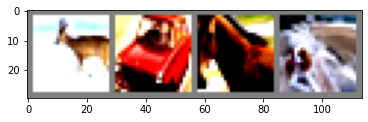

In [9]:
import misc
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

misc.show_images(sample_loader, classes)

In [10]:
import reg_tech

model = net.to(device)
optimizer_testing = reg_tech.hi_optimizer(model, 0.0002)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer_testing, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=0.2, num_iter=100, step_mode="exp")


Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 4.31E-03


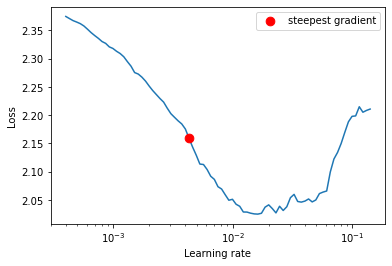

(<matplotlib.axes._subplots.AxesSubplot at 0x7f22e02b68d0>,
 0.004308869380063767)

In [11]:
lr_finder.plot()

In [12]:
optimizer = reg_tech.hi_optimizer(model, 0.00431)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
model = net.to(device)

In [13]:
for epoch in range(1, 50):
    training.train(model, device, train_loader, optimizer, epoch)
    test_loss = testing.test(model, device, test_loader)
    scheduler.step(test_loss)
    print('Epoch-{0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))

Loss=1.6461856365203857 Batch_id=390 Accuracy=34.03: 100%|██████████| 391/391 [00:40<00:00,  9.58it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0126, Accuracy: 4032/10000 (40.32%)

Epoch-1 lr: 0.00431


Loss=1.307793378829956 Batch_id=390 Accuracy=43.60: 100%|██████████| 391/391 [00:39<00:00,  9.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0116, Accuracy: 4549/10000 (45.49%)

Epoch-2 lr: 0.00431


Loss=1.220731496810913 Batch_id=390 Accuracy=49.45: 100%|██████████| 391/391 [00:40<00:00,  9.75it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0108, Accuracy: 5111/10000 (51.11%)

Epoch-3 lr: 0.00431


Loss=1.202911615371704 Batch_id=390 Accuracy=54.18: 100%|██████████| 391/391 [00:39<00:00,  9.79it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0105, Accuracy: 5087/10000 (50.87%)

Epoch-4 lr: 0.00431


Loss=1.2606115341186523 Batch_id=390 Accuracy=58.17: 100%|██████████| 391/391 [00:40<00:00,  9.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0094, Accuracy: 5762/10000 (57.62%)

Epoch-5 lr: 0.00431


Loss=0.9911291003227234 Batch_id=390 Accuracy=61.76: 100%|██████████| 391/391 [00:40<00:00,  9.77it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0088, Accuracy: 6084/10000 (60.84%)

Epoch-6 lr: 0.00431


Loss=0.8050872087478638 Batch_id=390 Accuracy=64.48: 100%|██████████| 391/391 [00:40<00:00,  9.76it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0077, Accuracy: 6539/10000 (65.39%)

Epoch-7 lr: 0.00431


Loss=1.0951433181762695 Batch_id=390 Accuracy=66.93: 100%|██████████| 391/391 [00:39<00:00,  9.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0071, Accuracy: 6799/10000 (67.99%)

Epoch-8 lr: 0.00431


Loss=0.9824904203414917 Batch_id=390 Accuracy=69.02: 100%|██████████| 391/391 [00:39<00:00,  9.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0074, Accuracy: 6694/10000 (66.94%)

Epoch-9 lr: 0.00431


Loss=0.7511289715766907 Batch_id=390 Accuracy=71.13: 100%|██████████| 391/391 [00:40<00:00,  9.75it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0068, Accuracy: 7013/10000 (70.13%)

Epoch-10 lr: 0.00431


Loss=0.6006780862808228 Batch_id=390 Accuracy=72.51: 100%|██████████| 391/391 [00:40<00:00,  9.76it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0075, Accuracy: 6892/10000 (68.92%)

Epoch-11 lr: 0.00431


Loss=0.6971939206123352 Batch_id=390 Accuracy=74.37: 100%|██████████| 391/391 [00:40<00:00,  9.75it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0068, Accuracy: 6994/10000 (69.94%)

Epoch-12 lr: 0.00431


Loss=0.5871752500534058 Batch_id=390 Accuracy=75.63: 100%|██████████| 391/391 [00:40<00:00,  9.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 7490/10000 (74.90%)

Epoch-13 lr: 0.00431


Loss=0.620134711265564 Batch_id=390 Accuracy=76.68: 100%|██████████| 391/391 [00:40<00:00,  9.75it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 7594/10000 (75.94%)

Epoch-14 lr: 0.00431


Loss=0.5338943004608154 Batch_id=390 Accuracy=77.66: 100%|██████████| 391/391 [00:39<00:00,  9.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 7748/10000 (77.48%)

Epoch-15 lr: 0.00431


Loss=0.9554741978645325 Batch_id=390 Accuracy=78.75: 100%|██████████| 391/391 [00:40<00:00,  9.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 7735/10000 (77.35%)

Epoch-16 lr: 0.00431


Loss=0.5496005415916443 Batch_id=390 Accuracy=79.39: 100%|██████████| 391/391 [00:40<00:00,  9.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 7989/10000 (79.89%)

Epoch-17 lr: 0.00431


Loss=0.5493620038032532 Batch_id=390 Accuracy=80.26: 100%|██████████| 391/391 [00:40<00:00,  9.75it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 7814/10000 (78.14%)

Epoch-18 lr: 0.00431


Loss=0.3837466835975647 Batch_id=390 Accuracy=81.19: 100%|██████████| 391/391 [00:40<00:00,  9.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 7870/10000 (78.70%)

Epoch-19 lr: 0.00431


Loss=0.6959283947944641 Batch_id=390 Accuracy=81.74: 100%|██████████| 391/391 [00:40<00:00,  9.77it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8141/10000 (81.41%)

Epoch-20 lr: 0.00431


Loss=0.742152988910675 Batch_id=390 Accuracy=82.57: 100%|██████████| 391/391 [00:40<00:00,  9.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 7714/10000 (77.14%)

Epoch-21 lr: 0.00431


Loss=0.5186686515808105 Batch_id=390 Accuracy=82.87: 100%|██████████| 391/391 [00:40<00:00,  9.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8309/10000 (83.09%)

Epoch-22 lr: 0.00431


Loss=0.5670963525772095 Batch_id=390 Accuracy=83.62: 100%|██████████| 391/391 [00:40<00:00,  9.75it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8284/10000 (82.84%)

Epoch-23 lr: 0.00431


Loss=0.562085747718811 Batch_id=390 Accuracy=84.12: 100%|██████████| 391/391 [00:40<00:00,  9.75it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8224/10000 (82.24%)

Epoch-24 lr: 0.00431


Loss=0.6065784692764282 Batch_id=390 Accuracy=84.65: 100%|██████████| 391/391 [00:40<00:00,  9.76it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8304/10000 (83.04%)

Epoch-25 lr: 0.00431


Loss=0.48591548204421997 Batch_id=390 Accuracy=84.73: 100%|██████████| 391/391 [00:40<00:00,  9.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8327/10000 (83.27%)

Epoch-26 lr: 0.00431


Loss=0.6654836535453796 Batch_id=390 Accuracy=85.14: 100%|██████████| 391/391 [00:40<00:00,  9.75it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8229/10000 (82.29%)

Epoch-27 lr: 0.00431


Loss=0.5654303431510925 Batch_id=390 Accuracy=86.04: 100%|██████████| 391/391 [00:40<00:00,  9.75it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8251/10000 (82.51%)

Epoch-28 lr: 0.00431


Loss=0.25395315885543823 Batch_id=390 Accuracy=86.05: 100%|██████████| 391/391 [00:40<00:00,  9.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8397/10000 (83.97%)

Epoch-29 lr: 0.00431


Loss=0.38219884037971497 Batch_id=390 Accuracy=86.53: 100%|██████████| 391/391 [00:40<00:00,  9.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8473/10000 (84.73%)

Epoch-30 lr: 0.00431


Loss=0.3718344569206238 Batch_id=390 Accuracy=86.88: 100%|██████████| 391/391 [00:40<00:00,  9.76it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8510/10000 (85.10%)

Epoch-31 lr: 0.00431


Loss=0.369553804397583 Batch_id=390 Accuracy=87.40: 100%|██████████| 391/391 [00:40<00:00,  9.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 8095/10000 (80.95%)

Epoch-32 lr: 0.00431


Loss=0.3844620883464813 Batch_id=390 Accuracy=87.58: 100%|██████████| 391/391 [00:40<00:00,  9.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8545/10000 (85.45%)

Epoch-33 lr: 0.00431


Loss=0.3855475187301636 Batch_id=390 Accuracy=87.62: 100%|██████████| 391/391 [00:39<00:00,  9.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8632/10000 (86.32%)

Epoch-34 lr: 0.00431


Loss=0.3181610703468323 Batch_id=390 Accuracy=88.13: 100%|██████████| 391/391 [00:40<00:00,  9.76it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8689/10000 (86.89%)

Epoch-35 lr: 0.00431


Loss=0.33040910959243774 Batch_id=390 Accuracy=88.52: 100%|██████████| 391/391 [00:40<00:00,  9.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8430/10000 (84.30%)

Epoch-36 lr: 0.00431


Loss=0.3900311589241028 Batch_id=390 Accuracy=88.84: 100%|██████████| 391/391 [00:40<00:00,  9.75it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8585/10000 (85.85%)

Epoch-37 lr: 0.00431


Loss=0.2345087230205536 Batch_id=390 Accuracy=89.18: 100%|██████████| 391/391 [00:40<00:00,  9.77it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8652/10000 (86.52%)

Epoch-38 lr: 0.00431


Loss=0.3737536668777466 Batch_id=390 Accuracy=89.18: 100%|██████████| 391/391 [00:40<00:00,  9.76it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8615/10000 (86.15%)

Epoch-39 lr: 0.00431


Loss=0.33263301849365234 Batch_id=390 Accuracy=89.58: 100%|██████████| 391/391 [00:40<00:00,  9.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8698/10000 (86.98%)

Epoch-40 lr: 0.00431


Loss=0.2657589018344879 Batch_id=390 Accuracy=89.63: 100%|██████████| 391/391 [00:40<00:00,  9.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8676/10000 (86.76%)

Epoch-41 lr: 0.00431


Loss=0.28424566984176636 Batch_id=390 Accuracy=90.02: 100%|██████████| 391/391 [00:40<00:00,  9.69it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8611/10000 (86.11%)

Epoch-42 lr: 0.00431


Loss=0.2299901247024536 Batch_id=390 Accuracy=89.94: 100%|██████████| 391/391 [00:40<00:00,  9.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8700/10000 (87.00%)

Epoch-43 lr: 0.00431


Loss=0.29103487730026245 Batch_id=390 Accuracy=90.39: 100%|██████████| 391/391 [00:40<00:00,  9.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8655/10000 (86.55%)

Epoch-44 lr: 0.00431


Loss=0.16915012896060944 Batch_id=390 Accuracy=90.59: 100%|██████████| 391/391 [00:40<00:00,  9.70it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8724/10000 (87.24%)

Epoch-45 lr: 0.00431


Loss=0.2721835672855377 Batch_id=390 Accuracy=90.80: 100%|██████████| 391/391 [00:40<00:00,  9.71it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8661/10000 (86.61%)

Epoch-46 lr: 0.00043099999999999996


Loss=0.35739660263061523 Batch_id=390 Accuracy=92.93: 100%|██████████| 391/391 [00:40<00:00,  9.71it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8944/10000 (89.44%)

Epoch-47 lr: 0.00043099999999999996


Loss=0.10127235949039459 Batch_id=390 Accuracy=93.51: 100%|██████████| 391/391 [00:40<00:00,  9.72it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8972/10000 (89.72%)

Epoch-48 lr: 0.00043099999999999996


Loss=0.22802940011024475 Batch_id=390 Accuracy=93.70: 100%|██████████| 391/391 [00:40<00:00,  9.71it/s]



Test set: Average loss: 0.0027, Accuracy: 8987/10000 (89.87%)

Epoch-49 lr: 0.00043099999999999996


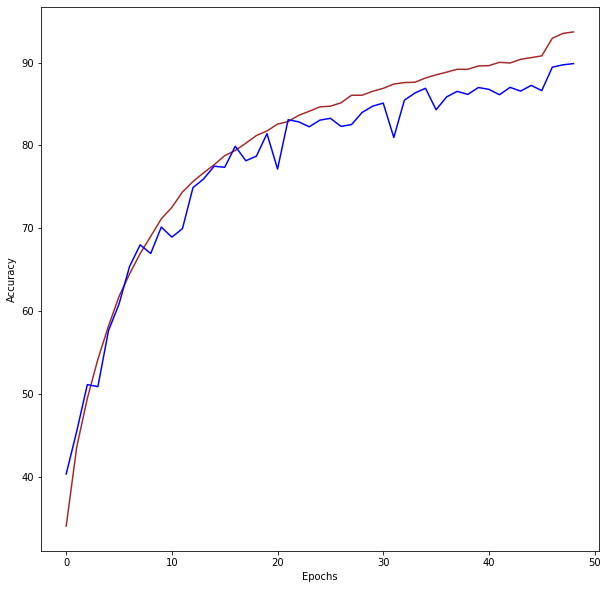

In [19]:


import matplotlib.pyplot as plt
epochs= 49
plt.figure(figsize=(10, 10))

plt.plot( range(epochs), training.train_acc, c= 'brown')
plt.plot( range(epochs), testing.test_acc, c= 'blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

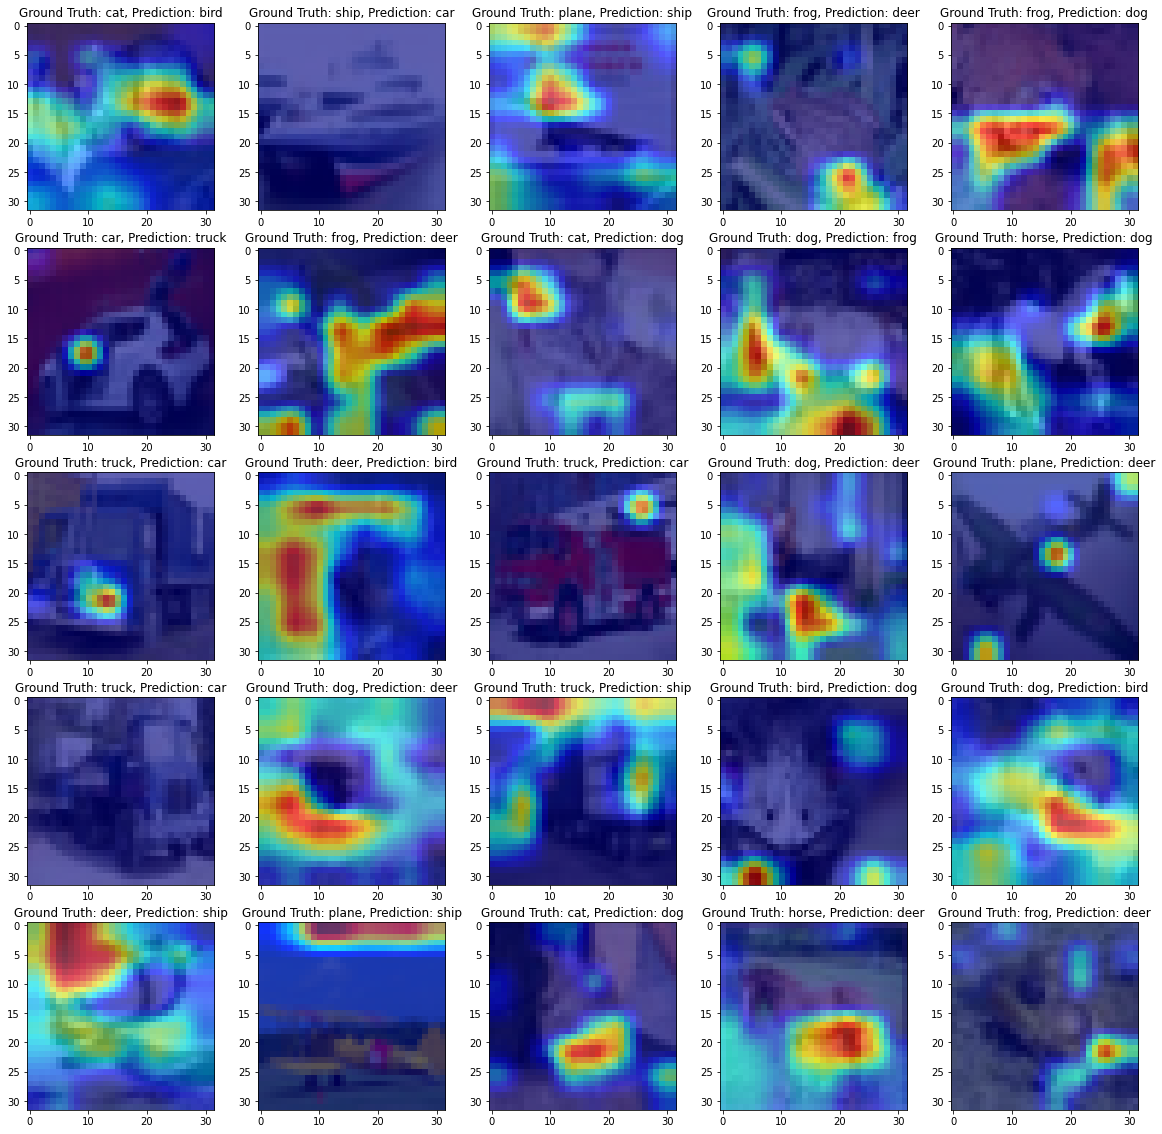

In [20]:
from grad_cam import run_gradcam

class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(20,20))
for num in range(25):
    image, label = run_gradcam(model, testing.wht_correct_dict['img'][num], int(testing.wht_correct_dict['prediction'][num]))
    plt.subplot(5,5,num+1)
    plt.imshow(image)
    plt.title(f"Ground Truth: {class_names[testing.wht_correct_dict['target'][num]]}, Prediction: {class_names[testing.wht_correct_dict['prediction'][num]]}")